In [81]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

# For data preparation
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tsaug.visualization import plot
from tsaug import TimeWarp, Drift, AddNoise
from imblearn.over_sampling import SMOTE


# For Tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, MaxPool1D, GlobalAvgPool1D, Conv1D, Dropout, BatchNormalization

# for callback
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
moncapteur = pd.read_csv('./capteurs/capteur1.csv')
moncapteur.drop(['class'], inplace=True, axis=1)
moncapteur

,0,1,2,3,4,5,6,7,8,9,...,3990,3991,3992,3993,3994,3995,3996,3997,3998,3999
0,0.361,0.361,0.361,0.361,0.361,0.361,0.361,0.361,0.361,0.361,...,0.405,0.405,0.405,0.405,0.405,0.405,0.405,0.405,0.405,0.405
1,0.365,0.365,0.365,0.365,0.365,0.365,0.365,0.365,0.365,0.365,...,0.366,0.366,0.366,0.366,0.366,0.366,0.366,0.366,0.366,0.366
2,0.371,0.371,0.371,0.371,0.371,0.371,0.371,0.371,0.371,0.371,...,0.360,0.360,0.360,0.360,0.360,0.360,0.360,0.360,0.360,0.360
3,0.346,0.346,0.346,0.346,0.346,0.346,0.346,0.346,0.346,0.346,...,0.392,0.392,0.392,0.392,0.392,0.392,0.392,0.392,0.392,0.392
4,0.311,0.311,0.310,0.310,0.311,0.311,0.311,0.311,0.310,0.310,...,0.342,0.342,0.342,0.342,0.342,0.342,0.342,0.342,0.342,0.342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,0.534,0.534,0.534,0.533,0.534,0.534,0.534,0.534,0.534,0.534,...,0.534,0.534,0.534,0.534,0.534,0.534,0.534,0.534,0.534,0.534
74,0.528,0.528,0.528,0.528,0.528,0.528,0.528,0.528,0.528,0.528,...,0.536,0.536,0.536,0.536,0.536,0.536,0.536,0.536,0.536,0.536
75,0.542,0.542,0.542,0.542,0.542,0.542,0.542,0.542,0.542,0.542,...,0.537,0.537,0.537,0.537,0.537,0.537,0.537,0.537,0.537,0.537
76,0.532,0.532,0.532,0.532,0.532,0.532,0.532,0.532,0.532,0.532,...,0.533,0.533,0.534,0.534,0.533,0.533,0.532,0.533,0.534,0.534


In [48]:
def sensor_augmentor(data, min_drift=0.01, max_drift=0.5, noise_scale=0.01) :
    aug = list()
    data_np = data.to_numpy()
    my_augmenter = (
    TimeWarp() * 9  # random time warping 5 times in parallel
    + Drift(max_drift=(min_drift, max_drift), normalize=False) @ 0.8  # with 80% probability, random drift the signal up to 10% - 50%
    + AddNoise(scale = noise_scale, normalize=False)
    )
    for i in range(len(data_np)) :
        data_aug = my_augmenter.augment(data_np[i])
        aug.append(data_np[i])
        for j in range(len(data_aug)) :
            aug.append(data_aug[j])
    aug = pd.DataFrame(np.array(aug))
    return aug

In [49]:
moncapteur_aug = sensor_augmentor(moncapteur)
moncapteur_aug

,0,1,2,3,4,5,6,7,8,9,...,3990,3991,3992,3993,3994,3995,3996,3997,3998,3999
0,0.361000,0.361000,0.361000,0.361000,0.361000,0.361000,0.361000,0.361000,0.361000,0.361000,...,0.405000,0.405000,0.405000,0.405000,0.405000,0.405000,0.405000,0.405000,0.405000,0.405000
1,0.364156,0.378683,0.372879,0.361974,0.362171,0.371224,0.344020,0.352066,0.356300,0.365244,...,0.485993,0.463324,0.480339,0.476956,0.482231,0.466606,0.464111,0.469020,0.474191,0.468157
2,0.366862,0.356675,0.388042,0.352015,0.349150,0.349274,0.343032,0.338096,0.341106,0.343496,...,-0.014765,-0.025081,-0.032131,-0.022032,-0.033654,-0.048137,-0.029698,-0.017716,-0.032249,-0.034994
3,0.351590,0.349079,0.356407,0.362540,0.379932,0.366316,0.349279,0.355828,0.361407,0.335954,...,0.384784,0.389841,0.390302,0.404228,0.400156,0.419539,0.396586,0.410527,0.400557,0.385790
4,0.344956,0.336467,0.364882,0.368661,0.375884,0.367871,0.364426,0.357146,0.364711,0.370581,...,0.418301,0.408257,0.414288,0.396241,0.397301,0.397942,0.404936,0.411167,0.412672,0.411266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,0.497093,0.510929,0.513879,0.485446,0.477273,0.517910,0.505985,0.502690,0.511066,0.491397,...,0.418397,0.428239,0.432160,0.429026,0.420147,0.423853,0.438237,0.447698,0.416030,0.420932
776,0.503185,0.498814,0.488423,0.502799,0.499497,0.501253,0.493455,0.500181,0.505838,0.483716,...,0.577963,0.556866,0.556088,0.569385,0.562203,0.569491,0.573152,0.578188,0.568186,0.551418
777,0.494743,0.511701,0.509370,0.505052,0.509264,0.501589,0.510799,0.484825,0.498904,0.485448,...,0.537978,0.548109,0.515739,0.553441,0.529777,0.544534,0.519150,0.529582,0.529647,0.544920
778,0.493094,0.487513,0.515591,0.503687,0.504404,0.492395,0.503241,0.497535,0.484604,0.505965,...,0.541662,0.540490,0.521827,0.532745,0.526595,0.538083,0.524346,0.536636,0.552469,0.515137


## Les signaux concaténés 

In [50]:
def concat_dataset(path, test_size=0.3) :
    listefichier = os.listdir(path)
    monDataset = list()
    etiq = 0
    for file in listefichier :
        all_path = os.path.join(path,file)
        if not os.path.isdir(all_path) :
            monfichier = pd.read_csv(all_path)
            monfichier.drop(["class"], axis=1, inplace=True)
            monfichier.reset_index(inplace=True, drop=True)
            monDataset.append(monfichier)
        else :
            monfichier = os.listdir(all_path)
            all_path_etiq = os.path.join(all_path,monfichier[0])
            etiq = pd.read_csv(all_path_etiq)
            etiq["class"] = etiq["class"].astype('category').cat.codes
    monDataset = pd.concat(monDataset, axis=1)
    fv_train, fv_test, etiq_train, etiq_test = train_test_split(monDataset, etiq, test_size=test_size, random_state=42)
    return fv_train, fv_test, etiq_train, etiq_test

In [54]:
path = "./capteurs"
fv_train, fv_test, etiq_train, etiq_test = concat_dataset(path)
fv_train.shape, fv_test.shape, etiq_train.shape, etiq_test.shape

((54, 32000), (24, 32000), (54, 1), (24, 1))

### Augmentation des données

In [55]:
fv_train_aug = sensor_augmentor(fv_train, min_drift=0.01, max_drift=0.5, noise_scale=0.01)
fv_train_aug.shape

(540, 32000)

In [68]:
etiq_list = etiq_train.to_numpy()
etiq_list[1]

array([2], dtype=int8)

In [71]:
etiq_train_aug = list()
for i in range(len(etiq_list)) :
    for j in range(10) :
        etiq_train_aug.append(etiq_list[i])
etiq_train_aug = pd.DataFrame(etiq_train_aug)
etiq_train_aug.shape

(540, 1)

Epoch 1/50
108/108 [==============================] - ETA: 0s - loss: 1.2220 - accuracy: 0.5255
Epoch 1: accuracy improved from -inf to 0.52546, saving model to .\Model_CNN1D_32000_aug
INFO:tensorflow:Assets written to: .\Model_CNN1D_32000_aug\assets
108/108 [==============================] - 59s 529ms/step - loss: 1.2220 - accuracy: 0.5255 - val_loss: 1.2981 - val_accuracy: 0.4444
Epoch 2/50
108/108 [==============================] - ETA: 0s - loss: 1.1736 - accuracy: 0.5347
Epoch 2: accuracy improved from 0.52546 to 0.53472, saving model to .\Model_CNN1D_32000_aug
INFO:tensorflow:Assets written to: .\Model_CNN1D_32000_aug\assets
108/108 [==============================] - 47s 441ms/step - loss: 1.1736 - accuracy: 0.5347 - val_loss: 1.2628 - val_accuracy: 0.4444
Epoch 3/50
108/108 [==============================] - ETA: 0s - loss: 0.8564 - accuracy: 0.6620
Epoch 3: accuracy improved from 0.53472 to 0.66204, saving model to .\Model_CNN1D_32000_aug
INFO:tensorflow:Assets written to: .\Mo

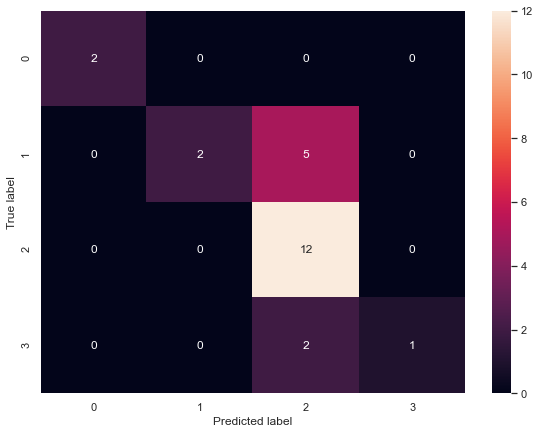

In [72]:
# Normalisation
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(np.transpose(fv_train_aug))
fv_train_aug = np.transpose(scaler.transform(np.transpose(fv_train_aug)))
scaler2 = MinMaxScaler(feature_range=(0,1))
scaler2.fit(np.transpose(fv_test))
fv_test = np.transpose(scaler2.transform(np.transpose(fv_test)))

# Reshaping 
fv_train_aug = np.expand_dims(fv_train_aug, axis=2)
fv_test = np.expand_dims(fv_test, axis=2)


# CNN Variables
# Première couche du CNN
filter_size1 = 5
num_filters1 = 64
# Deuxième couche du CNN 
filter_size2 = 5
num_filters2 = 32

batch_size = 4
num_channels = 1 # ! paramètre sur lequel on pourrait jouer si on ajoute les autres capteurs
n_epochs = 50
    

# CNN
path_to_save_model = './Model_CNN1D_32000_aug'
ckpt_saver = ModelCheckpoint(
path_to_save_model,
monitor='accuracy', # sur quoi on se base pour voir le meilleur
mode = 'max', # max de l'accuracy sur la validation
save_best_only = True,
save_freq='epoch', # ne voit qu'à la fin de l'époque
verbose=1
) 


model = tf.keras.Sequential(
[
    Input(shape=(32000,num_channels)), # format d'entrée
    Conv1D(filters=num_filters1, kernel_size=filter_size1, activation='relu'),
    Conv1D(filters=num_filters2, kernel_size=filter_size2, activation='relu'),
    Dropout(0.5),
    MaxPool1D(pool_size=2),
    Conv1D(filters=num_filters1, kernel_size=filter_size1, activation='relu'),
    Conv1D(filters=num_filters2, kernel_size=filter_size1, activation='relu'),
    Dropout(0.5),
    MaxPool1D(pool_size=2),
    GlobalAvgPool1D(),
    Dense(50, activation='relu'),
    Dense(4, activation='softmax')
]
)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
model.fit(fv_train_aug, etiq_train_aug, batch_size=batch_size, epochs=n_epochs, validation_split=0.2, callbacks=[ckpt_saver])

# Evaluation of the model
print("====== Modele evaluation ======")
model.evaluate(fv_test,etiq_test, batch_size=batch_size)
print("===============================")
y_model=model.predict(fv_test)
y_model_max = np.argmax(y_model, axis=1)
con_mat = tf.math.confusion_matrix(labels=etiq_test, predictions=y_model_max).numpy()

# Visualization
sns.set_theme(style='darkgrid')
plt.figure(figsize=(8, 6))
sns.heatmap(con_mat, annot=True)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Avec une autre disposition du dataset (on prend 50-50 test entrainement)

Epoch 1/50
78/78 [==============================] - ETA: 0s - loss: 1.2876 - accuracy: 0.4744
Epoch 1: accuracy improved from -inf to 0.47436, saving model to .\Model_CNN1D_32000_aug_2
INFO:tensorflow:Assets written to: .\Model_CNN1D_32000_aug_2\assets
78/78 [==============================] - 44s 561ms/step - loss: 1.2876 - accuracy: 0.4744 - val_loss: 1.2897 - val_accuracy: 0.4872
Epoch 2/50
78/78 [==============================] - ETA: 0s - loss: 1.2548 - accuracy: 0.4872
Epoch 2: accuracy improved from 0.47436 to 0.48718, saving model to .\Model_CNN1D_32000_aug_2
INFO:tensorflow:Assets written to: .\Model_CNN1D_32000_aug_2\assets
78/78 [==============================] - 48s 612ms/step - loss: 1.2548 - accuracy: 0.4872 - val_loss: 1.2656 - val_accuracy: 0.4872
Epoch 3/50
78/78 [==============================] - ETA: 0s - loss: 1.2293 - accuracy: 0.4872
Epoch 3: accuracy did not improve from 0.48718
78/78 [==============================] - 43s 551ms/step - loss: 1.2293 - accuracy: 0.4

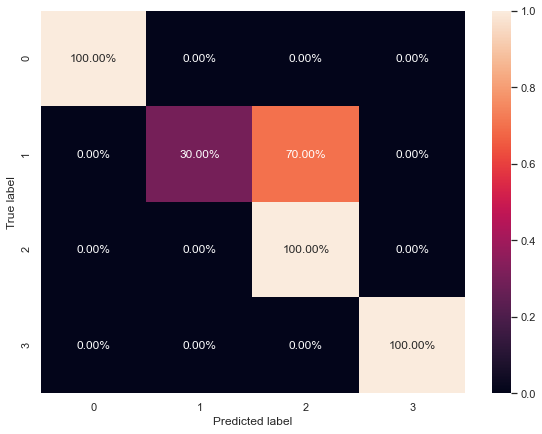

In [79]:
fv_train, fv_test, etiq_train, etiq_test = concat_dataset(path, test_size=0.5)

fv_train_aug = sensor_augmentor(fv_train, min_drift=0.01, max_drift=0.5, noise_scale=0.01)
fv_train_aug.shape

etiq_list = etiq_train.to_numpy()

etiq_train_aug = list()
for i in range(len(etiq_list)) :
    for j in range(10) :
        etiq_train_aug.append(etiq_list[i])
etiq_train_aug = pd.DataFrame(etiq_train_aug)

# Normalisation
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(np.transpose(fv_train_aug))
fv_train_aug = np.transpose(scaler.transform(np.transpose(fv_train_aug)))
scaler2 = MinMaxScaler(feature_range=(0,1))
scaler2.fit(np.transpose(fv_test))
fv_test = np.transpose(scaler2.transform(np.transpose(fv_test)))

# Reshaping 
fv_train_aug = np.expand_dims(fv_train_aug, axis=2)
fv_test = np.expand_dims(fv_test, axis=2)


# CNN Variables
# Première couche du CNN
filter_size1 = 5
num_filters1 = 64
# Deuxième couche du CNN 
filter_size2 = 5
num_filters2 = 32

batch_size = 4
num_channels = 1 # ! paramètre sur lequel on pourrait jouer si on ajoute les autres capteurs
n_epochs = 50
    

# CNN
path_to_save_model = './Model_CNN1D_32000_aug_2'
ckpt_saver = ModelCheckpoint(
path_to_save_model,
monitor='accuracy', # sur quoi on se base pour voir le meilleur
mode = 'max', # max de l'accuracy sur la validation
save_best_only = True,
save_freq='epoch', # ne voit qu'à la fin de l'époque
verbose=1
) 


model = tf.keras.Sequential(
[
    Input(shape=(32000,num_channels)), # format d'entrée
    Conv1D(filters=num_filters1, kernel_size=filter_size1, activation='relu'),
    Conv1D(filters=num_filters2, kernel_size=filter_size2, activation='relu'),
    Dropout(0.5),
    MaxPool1D(pool_size=2),
    Conv1D(filters=num_filters1, kernel_size=filter_size1, activation='relu'),
    Conv1D(filters=num_filters2, kernel_size=filter_size1, activation='relu'),
    Dropout(0.5),
    MaxPool1D(pool_size=2),
    GlobalAvgPool1D(),
    Dense(50, activation='relu'),
    Dense(4, activation='softmax')
]
)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
model.fit(fv_train_aug, etiq_train_aug, batch_size=batch_size, epochs=n_epochs, validation_split=0.2, callbacks=[ckpt_saver])

# Evaluation of the model
print("====== Modele evaluation ======")
model.evaluate(fv_test,etiq_test, batch_size=batch_size)
print("===============================")
y_model=model.predict(fv_test)
y_model_max = np.argmax(y_model, axis=1)
con_mat = tf.math.confusion_matrix(labels=etiq_test, predictions=y_model_max).numpy()

# Visualization
cmn = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]
sns.set_theme(style='darkgrid')
plt.figure(figsize=(8, 6))
sns.heatmap(cmn, annot=True, fmt='.2%')
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

On tente maintenant de rééquilibrer les classes et voir l'impact d'une telle opération

In [80]:
etiq_train_aug.value_counts()

2    190
1    100
0     60
3     40
dtype: int64

In [86]:
fv_train_aug_res = np.add.reduce(fv_train_aug, axis=2)
fv_train_aug.shape, fv_train_aug_res.shape

((390, 32000, 1), (390, 32000))

In [87]:
sm = SMOTE(random_state=42)
fv_train_aug_res, etiq_train_aug_res = sm.fit_resample(fv_train_aug_res, etiq_train_aug)
etiq_train_aug_res.value_counts()

0    190
1    190
2    190
3    190
dtype: int64

On restructure la matrices des caractéristiques

In [88]:
fv_train_aug_res = np.expand_dims(fv_train_aug_res, axis=2)

In [ ]:
# CNN
path_to_save_model = './Model_CNN1D_32000_aug_2'
ckpt_saver = ModelCheckpoint(
path_to_save_model,
monitor='accuracy', # sur quoi on se base pour voir le meilleur
mode = 'max', # max de l'accuracy sur la validation
save_best_only = True,
save_freq='epoch', # ne voit qu'à la fin de l'époque
verbose=1
) 


model = tf.keras.Sequential(
[
    Input(shape=(32000,num_channels)), # format d'entrée
    Conv1D(filters=num_filters1, kernel_size=filter_size1, activation='relu'),
    Conv1D(filters=num_filters2, kernel_size=filter_size2, activation='relu'),
    Dropout(0.5),
    MaxPool1D(pool_size=2),
    Conv1D(filters=num_filters1, kernel_size=filter_size1, activation='relu'),
    Conv1D(filters=num_filters2, kernel_size=filter_size1, activation='relu'),
    Dropout(0.5),
    MaxPool1D(pool_size=2),
    GlobalAvgPool1D(),
    Dense(50, activation='relu'),
    Dense(4, activation='softmax')
]
)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
model.fit(fv_train_aug, etiq_train_aug, batch_size=batch_size, epochs=n_epochs, validation_split=0.2, callbacks=[ckpt_saver])

# Evaluation of the model
print("====== Modele evaluation ======")
model.evaluate(fv_test,etiq_test, batch_size=batch_size)
print("===============================")
y_model=model.predict(fv_test)
y_model_max = np.argmax(y_model, axis=1)
con_mat = tf.math.confusion_matrix(labels=etiq_test, predictions=y_model_max).numpy()

# Visualization
cmn = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]
sns.set_theme(style='darkgrid')
plt.figure(figsize=(8, 6))
sns.heatmap(cmn, annot=True, fmt='.2%')
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Epoch 1/50
152/152 [==============================] - ETA: 0s - loss: 1.2420 - accuracy: 0.3569
Epoch 1: accuracy improved from -inf to 0.35691, saving model to .\Model_CNN1D_32000_aug_4
INFO:tensorflow:Assets written to: .\Model_CNN1D_32000_aug_4\assets
152/152 [==============================] - 79s 512ms/step - loss: 1.2420 - accuracy: 0.3569 - val_loss: 1.7605 - val_accuracy: 0.0000e+00
Epoch 2/50
152/152 [==============================] - ETA: 0s - loss: 0.8672 - accuracy: 0.6382
Epoch 2: accuracy improved from 0.35691 to 0.63816, saving model to .\Model_CNN1D_32000_aug_4
INFO:tensorflow:Assets written to: .\Model_CNN1D_32000_aug_4\assets
152/152 [==============================] - 84s 557ms/step - loss: 0.8672 - accuracy: 0.6382 - val_loss: 1.5540 - val_accuracy: 0.0066
Epoch 3/50
152/152 [==============================] - ETA: 0s - loss: 0.6582 - accuracy: 0.7155
Epoch 3: accuracy improved from 0.63816 to 0.71546, saving model to .\Model_CNN1D_32000_aug_4
INFO:tensorflow:Assets wr

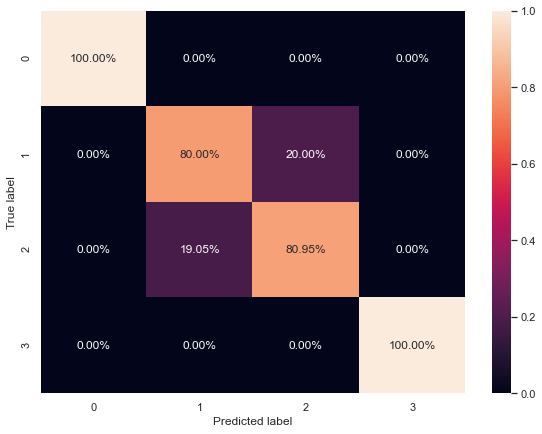

In [89]:
# CNN
path_to_save_model = './Model_CNN1D_32000_aug_4'
ckpt_saver = ModelCheckpoint(
path_to_save_model,
monitor='accuracy', # sur quoi on se base pour voir le meilleur
mode = 'max', # max de l'accuracy sur la validation
save_best_only = True,
save_freq='epoch', # ne voit qu'à la fin de l'époque
verbose=1
) 


model = tf.keras.Sequential(
[
    Input(shape=(32000,num_channels)), # format d'entrée
    Conv1D(filters=num_filters1, kernel_size=filter_size1, activation='relu'),
    Conv1D(filters=num_filters2, kernel_size=filter_size2, activation='relu'),
    Dropout(0.5),
    MaxPool1D(pool_size=2),
    Conv1D(filters=num_filters1, kernel_size=filter_size1, activation='relu'),
    Conv1D(filters=num_filters2, kernel_size=filter_size1, activation='relu'),
    Dropout(0.5),
    MaxPool1D(pool_size=2),
    GlobalAvgPool1D(),
    Dense(50, activation='relu'),
    Dense(4, activation='softmax')
]
)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
model.fit(fv_train_aug_res, etiq_train_aug_res, batch_size=batch_size, epochs=n_epochs, validation_split=0.2, callbacks=[ckpt_saver])

# Evaluation of the model
print("====== Modele evaluation ======")
model.evaluate(fv_test,etiq_test, batch_size=batch_size)
print("===============================")
y_model=model.predict(fv_test)
y_model_max = np.argmax(y_model, axis=1)
con_mat = tf.math.confusion_matrix(labels=etiq_test, predictions=y_model_max).numpy()

# Visualization
cmn = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]
sns.set_theme(style='darkgrid')
plt.figure(figsize=(8, 6))
sns.heatmap(cmn, annot=True, fmt='.2%')
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

On essai maintenant avec un ratio 60% de test - 40% d'entrainement

Epoch 1/50
62/62 [==============================] - ETA: 0s - loss: 1.2785 - accuracy: 0.4718
Epoch 1: accuracy improved from -inf to 0.47177, saving model to .\Model_CNN1D_32000_aug_3
INFO:tensorflow:Assets written to: .\Model_CNN1D_32000_aug_3\assets
62/62 [==============================] - 35s 536ms/step - loss: 1.2785 - accuracy: 0.4718 - val_loss: 1.2889 - val_accuracy: 0.4839
Epoch 2/50
62/62 [==============================] - ETA: 0s - loss: 1.2400 - accuracy: 0.4839
Epoch 2: accuracy improved from 0.47177 to 0.48387, saving model to .\Model_CNN1D_32000_aug_3
INFO:tensorflow:Assets written to: .\Model_CNN1D_32000_aug_3\assets
62/62 [==============================] - 33s 535ms/step - loss: 1.2400 - accuracy: 0.4839 - val_loss: 1.2202 - val_accuracy: 0.4839
Epoch 3/50
62/62 [==============================] - ETA: 0s - loss: 1.0836 - accuracy: 0.5726
Epoch 3: accuracy improved from 0.48387 to 0.57258, saving model to .\Model_CNN1D_32000_aug_3
INFO:tensorflow:Assets written to: .\Mo

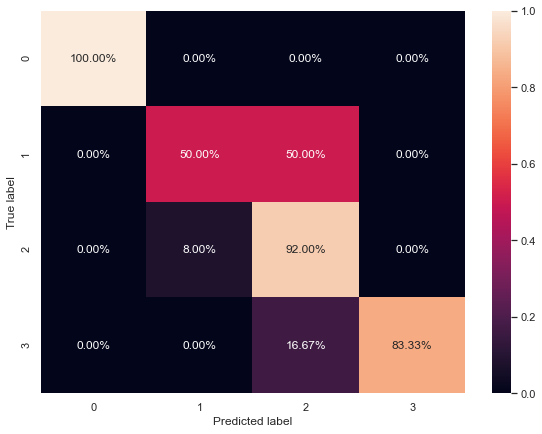

In [78]:
fv_train, fv_test, etiq_train, etiq_test = concat_dataset(path, test_size=0.6)

fv_train_aug = sensor_augmentor(fv_train, min_drift=0.01, max_drift=0.5, noise_scale=0.01)
fv_train_aug.shape

etiq_list = etiq_train.to_numpy()

etiq_train_aug = list()
for i in range(len(etiq_list)) :
    for j in range(10) :
        etiq_train_aug.append(etiq_list[i])
etiq_train_aug = pd.DataFrame(etiq_train_aug)

# Normalisation
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(np.transpose(fv_train_aug))
fv_train_aug = np.transpose(scaler.transform(np.transpose(fv_train_aug)))
scaler2 = MinMaxScaler(feature_range=(0,1))
scaler2.fit(np.transpose(fv_test))
fv_test = np.transpose(scaler2.transform(np.transpose(fv_test)))

# Reshaping 
fv_train_aug = np.expand_dims(fv_train_aug, axis=2)
fv_test = np.expand_dims(fv_test, axis=2)


# CNN Variables
# Première couche du CNN
filter_size1 = 5
num_filters1 = 64
# Deuxième couche du CNN 
filter_size2 = 5
num_filters2 = 32

batch_size = 4
num_channels = 1 # ! paramètre sur lequel on pourrait jouer si on ajoute les autres capteurs
n_epochs = 50
    

# CNN
path_to_save_model = './Model_CNN1D_32000_aug_2'
ckpt_saver = ModelCheckpoint(
path_to_save_model,
monitor='accuracy', # sur quoi on se base pour voir le meilleur
mode = 'max', # max de l'accuracy sur la validation
save_best_only = True,
save_freq='epoch', # ne voit qu'à la fin de l'époque
verbose=1
) 


model = tf.keras.Sequential(
[
    Input(shape=(32000,num_channels)), # format d'entrée
    Conv1D(filters=num_filters1, kernel_size=filter_size1, activation='relu'),
    Conv1D(filters=num_filters2, kernel_size=filter_size2, activation='relu'),
    Dropout(0.5),
    MaxPool1D(pool_size=2),
    Conv1D(filters=num_filters1, kernel_size=filter_size1, activation='relu'),
    Conv1D(filters=num_filters2, kernel_size=filter_size1, activation='relu'),
    Dropout(0.5),
    MaxPool1D(pool_size=2),
    GlobalAvgPool1D(),
    Dense(50, activation='relu'),
    Dense(4, activation='softmax')
]
)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
model.fit(fv_train_aug, etiq_train_aug, batch_size=batch_size, epochs=n_epochs, validation_split=0.2, callbacks=[ckpt_saver])

# Evaluation of the model
print("====== Modele evaluation ======")
model.evaluate(fv_test,etiq_test, batch_size=batch_size)
print("===============================")
y_model=model.predict(fv_test)
y_model_max = np.argmax(y_model, axis=1)
con_mat = tf.math.confusion_matrix(labels=etiq_test, predictions=y_model_max).numpy()

# Visualization
sns.set_theme(style='darkgrid')
plt.figure(figsize=(8, 6))
sns.heatmap(con_mat/np.sum(con_mat), annot=True, fmt='.2%')
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Signaux empilés